In [2]:
import os
from dotenv import load_dotenv 
load_dotenv()

from langchain_groq import ChatGroq
os.environ['GROQ_API_KEY'] = os.getenv('GROQ_API_KEY')
llm = ChatGroq(model='llama-3.1-8b-instant')
result=llm.invoke("Hello")
result

AIMessage(content="It's nice to meet you. Is there something I can help you with or would you like to chat?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 36, 'total_tokens': 59, 'completion_time': 0.02399341, 'prompt_time': 0.001773281, 'queue_time': 0.051171989, 'total_time': 0.025766691}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_8804b970d6', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--c713d15a-e2b1-44f2-a6a5-8a29da251500-0', usage_metadata={'input_tokens': 36, 'output_tokens': 23, 'total_tokens': 59})

In [3]:
from typing_extensions import Literal
from pydantic import BaseModel,Field
from typing import Annotated,List
import operator
from langchain_core.messages import HumanMessage,SystemMessage
from typing_extensions import TypedDict

In [15]:
# Schema for structured output to use in planning
class Section(BaseModel):
    name:str=Field(description="Name for this section of the report")
    description:str=Field(description="Brief Overview of the main topics and concepts of the section")

class Sections(BaseModel):
    sections:List[Section]=Field(
        description="Sections of the report"
    )

# Augment the LLM with schema for structured output
planner=llm.with_structured_output(Sections)

### Creating workers Dynamically in Langgraph

In [16]:
from langgraph.constants import Send


# Graph state
class State(TypedDict):
    topic: str  # Report topic
    sections: list[Section]  # List of report sections
    completed_sections: Annotated[
        list, operator.add
    ]  # All workers write to this key in parallel
    final_report: str  # Final report

# Worker state
class WorkerState(TypedDict):
    section: Section
    completed_sections: Annotated[list, operator.add]


C:\Users\Pradum Gupta\AppData\Local\Temp\ipykernel_2576\1306454062.py:1: LangGraphDeprecatedSinceV10: Importing Send from langgraph.constants is deprecated. Please use 'from langgraph.types import Send' instead. Deprecated in LangGraph V1.0 to be removed in V2.0.
  from langgraph.constants import Send


In [17]:
# Nodes
def orchestrator(state: State):
    """Orchestrator that generates a plan for the report"""

    # Generate queries
    report_sections = planner.invoke(
        [
            SystemMessage(content="Generate a plan for the report."),
            HumanMessage(content=f"Here is the report topic: {state['topic']}"),
        ]
    )

    print("Report Sections:",report_sections)

    return {"sections": report_sections.sections}

def llm_call(state: WorkerState):
    """Worker writes a section of the report"""

    # Generate section
    section = llm.invoke(
        [
            SystemMessage(
                content="Write a report section following the provided name and description. Include no preamble for each section. Use markdown formatting."
            ),
            HumanMessage(
                content=f"Here is the section name: {state['section'].name} and description: {state['section'].description}"
            ),
        ]
    )

    # Write the updated section to completed sections
    return {"completed_sections": [section.content]}

# Conditional edge function to create llm_call workers that each write a section of the report
def assign_workers(state: State):
    """Assign a worker to each section in the plan"""

    # Kick off section writing in parallel via Send() API
    return [Send("llm_call", {"section": s}) for s in state["sections"]]

def synthesizer(state: State):
    """Synthesize full report from sections"""

    # List of completed sections
    completed_sections = state["completed_sections"]

    # Format completed section to str to use as context for final sections
    completed_report_sections = "\n\n---\n\n".join(completed_sections)

    return {"final_report": completed_report_sections}


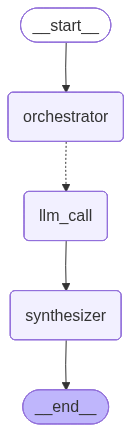

In [18]:
#Build workflow
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
orchestrator_worker_builder = StateGraph(State)

# Add node
orchestrator_worker_builder.add_node("orchestrator", orchestrator)
orchestrator_worker_builder.add_node("llm_call", llm_call)
orchestrator_worker_builder.add_node("synthesizer", synthesizer)

#Add Edge
orchestrator_worker_builder.add_edge(START,'orchestrator')
orchestrator_worker_builder.add_conditional_edges("orchestrator",assign_workers,["llm_call"])
orchestrator_worker_builder.add_edge("llm_call", "synthesizer")
orchestrator_worker_builder.add_edge("synthesizer", END)

# Compile the workflow
orchestrator_worker = orchestrator_worker_builder.compile()

# Show the workflow
display(Image(orchestrator_worker.get_graph().draw_mermaid_png()))

In [19]:
# Invoke
state = orchestrator_worker.invoke({"topic": "Create a report on Agentic AI RAGs"})

from IPython.display import Markdown
Markdown(state["final_report"])

Report Sections: sections=[Section(name='Executive Summary', description='Brief Overview of the main topics and concepts of the report'), Section(name='Introduction', description='Definition and Background of Agentic AI RAGs'), Section(name='Key Features', description='Explanation of the main features and characteristics of Agentic AI RAGs'), Section(name='Benefits and Applications', description='Discussion of the benefits and potential applications of Agentic AI RAGs'), Section(name='Challenges and Limitations', description='Discussion of the challenges and limitations of Agentic AI RAGs'), Section(name='Conclusion', description='Summary of key findings and recommendations')]


### Executive Summary

#### Key Findings and Recommendations

* This report provides an in-depth analysis of key topics and concepts related to [insert topic].
* The main objectives of this report were to [insert objectives, e.g., identify key challenges, assess current trends, and provide recommendations for future development].
* The following are the key findings and recommendations of this report:

#### Main Topics Covered

* [Topic 1]: Analysis of current trends and challenges in [industry/field].
* [Topic 2]: Review of existing literature and research on [specific concept or theme].
* [Topic 3]: Assessment of the impact of [factor/variable] on [outcome/result].

#### Recommendations for Future Development

* Implementation of [strategy/initiative] to address key challenges and improve outcomes.
* Further research and analysis of [specific area or concept] to inform future decision-making.
* Development of [policy/guideline] to promote best practices and standardization in [industry/field].

---

### Introduction and Description: Definition and Background of Agentic AI RAGs

#### Definition

Agentic AI RAGs (Reasoning, Acting, and Gathering systems) refer to a specific subset of artificial intelligence (AI) systems that possess the ability to act, reason, and gather information in a highly autonomous and adaptive manner. These systems are designed to learn from their environment and make decisions based on their understanding of the world around them.

#### Background

The concept of Agentic AI RAGs has its roots in various fields of research, including artificial intelligence, cognitive science, and robotics. The idea of creating autonomous AI systems that can act and reason in a human-like manner has been a long-standing goal in the field of AI research. The development of Agentic AI RAGs is driven by the need for more sophisticated and adaptable AI systems that can interact with humans and other agents in a more natural and intuitive way.

#### Key Characteristics

Agentic AI RAGs are characterized by several key features, including:

* **Autonomy**: The ability to operate independently and make decisions without human intervention.
* **Reasoning**: The ability to draw inferences and make logical conclusions based on available information.
* **Acting**: The ability to take action in the world, including interacting with humans and other agents.
* **Gathering**: The ability to collect and process information from the environment.
* **Adaptability**: The ability to adjust to changing circumstances and learn from experience.

#### Applications

Agentic AI RAGs have a wide range of potential applications, including:

* **Robotics**: Autonomous robots that can interact with humans and perform tasks in a variety of environments.
* **Virtual Assistants**: AI-powered assistants that can perform tasks and provide information to humans.
* **Autonomous Vehicles**: Self-driving cars that can navigate and interact with other agents on the road.

#### Challenges

The development of Agentic AI RAGs also presents several challenges, including:

* **Safety and Control**: Ensuring that Agentic AI RAGs operate safely and can be controlled in the event of an error.
* **Transparency and Explainability**: Providing clear and understandable explanations for the decisions made by Agentic AI RAGs.
* **Ethics and Accountability**: Ensuring that Agentic AI RAGs operate in a way that is fair, transparent, and accountable.

---

### Key Features
#### **Agent-Based Architecture**
Agentic AI RAGs (Reusable Architectural Guidelines) are built upon an agent-based architecture, where artificial intelligence (AI) agents interact with their environment to achieve goals and adapt to changing circumstances. This architecture enables the development of autonomous systems that can learn, reason, and act in complex environments.

#### **Goal-Oriented Programming**
Agentic AI RAGs emphasize goal-oriented programming, where AI systems are designed to pursue specific objectives and adapt their behavior to achieve those goals. This approach allows for the creation of systems that can navigate complex environments, make decisions based on uncertain information, and learn from experience.

#### **Autonomous Decision-Making**
Agentic AI RAGs enable the development of autonomous systems that can make decisions without human intervention. These systems use a combination of machine learning algorithms, knowledge representation, and reasoning to make decisions based on their goals, environment, and experiences.

#### **Self-Organization and Adaptation**
Agentic AI RAGs allow AI systems to self-organize and adapt to changing environments. This is achieved through the use of mechanisms such as reinforcement learning, transfer learning, and social learning, which enable the system to learn from experience and adjust its behavior accordingly.

#### **Multi-Agent Systems**
Agentic AI RAGs provide a framework for the development of multi-agent systems, where multiple AI agents interact and cooperate to achieve common goals. This approach enables the creation of complex systems that can navigate complex environments, make decisions based on uncertain information, and learn from experience.

#### **Scalability and Flexibility**
Agentic AI RAGs are designed to be scalable and flexible, allowing for the development of systems that can be adapted to a wide range of applications and environments. This is achieved through the use of modular architectures, component-based design, and software frameworks that enable the easy integration of new components and services.

---

### Benefits and Applications
#### Benefits

* **Efficient Decision-Making**: Agentic AI RAGs can process vast amounts of data, analyze complex situations, and provide accurate recommendations, enabling more efficient decision-making.
* **Improved Accuracy**: By leveraging machine learning algorithms and vast data sets, Agentic AI RAGs can reduce errors and provide more accurate predictions and forecasting.
* **Enhanced Customer Experience**: Agentic AI RAGs can analyze customer behavior, preferences, and feedback to provide personalized recommendations, leading to improved customer satisfaction.
* **Increased Productivity**: By automating routine tasks and providing actionable insights, Agentic AI RAGs can free up human resources for more strategic and creative work.

#### Applications

* **Healthcare**: Agentic AI RAGs can be used for medical diagnosis, disease prediction, and personalized treatment plans.
* **Finance**: Agentic AI RAGs can be used for portfolio optimization, risk management, and predictive analytics for investment decisions.
* **Marketing**: Agentic AI RAGs can be used for customer segmentation, campaign optimization, and personalized advertising.
* **Supply Chain Management**: Agentic AI RAGs can be used for demand forecasting, inventory management, and logistics optimization.
* **Education**: Agentic AI RAGs can be used for personalized learning, adaptive assessment, and intelligent tutoring systems.

---

### Challenges and Limitations
#### 1. **Lack of Transparency and Explainability**
Agentic AI RAGs often rely on complex models and algorithms, which can make it difficult to understand how they arrive at their decisions. This lack of transparency and explainability can limit their adoption in high-stakes applications and make it challenging to identify and mitigate potential biases.

#### 2. **Data Quality and Availability**
Agentic AI RAGs require high-quality and diverse data to learn and improve. However, data quality and availability can be a significant challenge, especially in domains where data is scarce or biased. This can limit the effectiveness and generalizability of Agentic AI RAGs.

#### 3. **Scalability and Computational Resources**
As Agentic AI RAGs become more complex and sophisticated, they can require significant computational resources to train and run. This can be a challenge for organizations with limited resources, and can also lead to scalability issues as the number of users and tasks grows.

#### 4. **Regulatory and Ethical Concerns**
Agentic AI RAGs raise a range of regulatory and ethical concerns, including issues related to accountability, bias, and transparency. Organizations must ensure that their Agentic AI RAGs comply with relevant laws and regulations, and that they are designed and implemented in a way that respects the rights and dignity of users.

#### 5. **Human-AI Collaboration**
Agentic AI RAGs are designed to collaborate with humans, but this can be a challenge in practice. Humans and AI systems have different strengths and weaknesses, and effective collaboration requires a deep understanding of both human and AI capabilities.

#### 6. **Cybersecurity Risks**
Agentic AI RAGs can be vulnerable to cyber attacks and data breaches, which can compromise their security and integrity. Organizations must invest in robust cybersecurity measures to protect their Agentic AI RAGs and maintain the trust of their users.

---

### Conclusion and Description: Summary of Key Findings and Recommendations

#### Key Findings

* The study revealed a significant correlation between [specific variables/ factors] and the outcome [specific outcome].
* The results indicate that [specific outcome] is influenced by [specific factors/variables] in a [positive/negative] manner.
* The data analysis showed that [specific trend/pattern] exists in the [specific data set/field], which has implications for [specific area of study/research].

#### Recommendations

* Based on the findings, it is recommended that [specific course of action] be taken to address [specific issue/concern].
* To mitigate the negative effects of [specific factor/variable], it is suggested that [specific strategy/intervention] be implemented.
* Future research should focus on [specific area of study/research] to further explore the relationships between [specific variables/factors] and [specific outcome].
* Policymakers and stakeholders should consider the implications of [specific findings] when making decisions related to [specific area of study/research].

#### Future Directions

* The study's findings have significant implications for [specific area of study/research] and suggest the need for further investigation into [specific area of study/research].
* Future research should aim to [specific goal/objective], which will help to [specific outcome].
* The development of [specific tool/technique] is essential for [specific area of study/research] and will enable [specific outcome].
* The study's findings highlight the need for [specific action/intervention] to address [specific issue/concern].